## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

C:\Users\rodri\AppData\Local\Temp\ipykernel_24368\2654227752.py:14: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_normalized)
C:\Users\rodri\AppData\Local\Temp\ipykernel_24368\2654227752.py:15: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


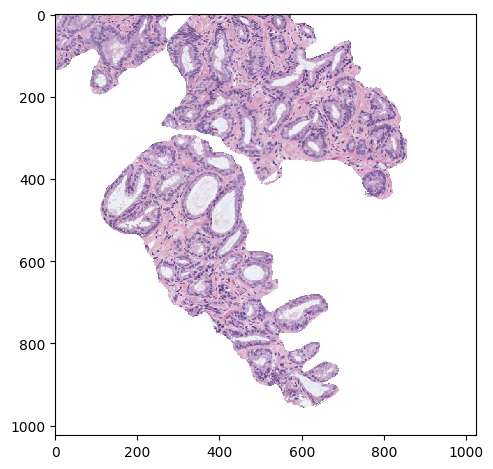

In [ ]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen
import numpy as np
from skimage import io

# Leer la imagen
image = io.imread('histo_2.jpg')

# Normalizar la imagen
image_normalized = image / 255.0

# Visualizar la imagen
io.imshow(image_normalized)
io.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

C:\Users\rodri\AppData\Local\Temp\ipykernel_24368\3842069964.py:7: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(magenta_channel, cmap='gray')
c:\Users\rodri\Dropbox\Business\VSC\Python\VIU\Actividad_Computer_Vision_C1\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
C:\Users\rodri\AppData\Local\Temp\ipykernel_24368\3842069964.py:8: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


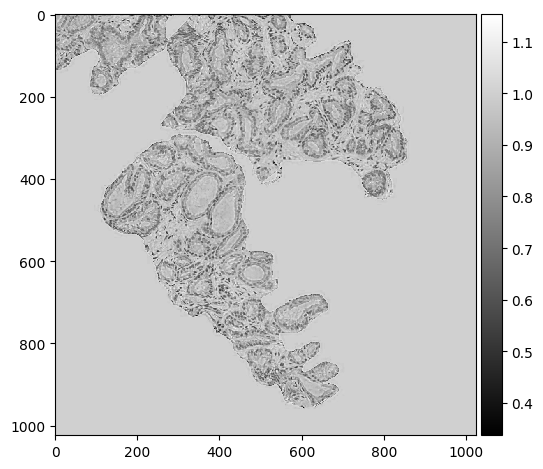

In [50]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

# Magenta = combinación de rojo + azul - verde
magenta_channel = image_normalized[:, :, 0] + image_normalized[:, :, 2] - image_normalized[:, :, 1]
# Visualizar el canal magenta
io.imshow(magenta_channel, cmap='gray')
io.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

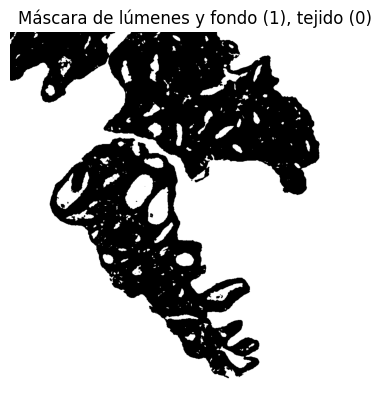

In [51]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

from matplotlib import pyplot as plt
from skimage import filters, color, img_as_ubyte
from skimage.color import rgb2gray
import cv2

# 1. Convertir la imagen a escala de grises
gray_image = rgb2gray(image_normalized)

# 2. Aplicar filtro gaussiano 5x5
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)

# 3. Convertir a uint8 en [0, 255] para Otsu
blurred_uint8 = img_as_ubyte(blurred)          # Escala a 0-255 y convierte a uint8

# 4. Calcular umbral de Otsu
otsu_thresh = filters.threshold_otsu(blurred_uint8)

# 5. Generar máscara binaria: 1 si fondo o lumen, 0 si tejido
mask = blurred_uint8 > otsu_thresh

# 6. Visualizar máscara
plt.imshow(mask, cmap='gray')
plt.title("Máscara de lúmenes y fondo (1), tejido (0)")
plt.axis('off')
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

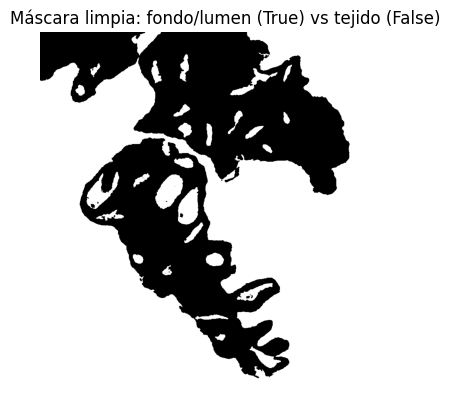

In [52]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology

# Supongamos que `mask` contiene True (1) para lumen/fondo y False (0) para tejido.

# Convertir a booleano (por si viene como int):
bool_mask = mask.astype(bool)

# Eliminar objetos pequeños (área mínima = 300 px, conectividad diagonal incluida):
clean_mask = morphology.remove_small_objects(
    bool_mask,
    min_size=300,
    connectivity=2,
)

# Visualizar la máscara resultante:
plt.imshow(clean_mask, cmap='gray')
plt.title("Máscara limpia: fondo/lumen (True) vs tejido (False)")
plt.axis('off')
plt.show()


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

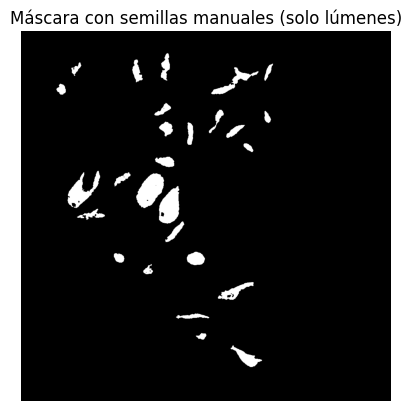

In [53]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

from skimage.measure import label, regionprops
import numpy as np

# Etiquetar todo lo que es True (fondo + lúmenes)
labeled = label(clean_mask, connectivity=2)

H, W = clean_mask.shape
lumen_mask = np.zeros_like(clean_mask, dtype=bool)

for r in regionprops(labeled):
    y0, x0, y1, x1 = r.bbox
    # Si toca cualquiera de los bordes, es fondo → descártalo
    if y0 == 0 or x0 == 0 or y1 == H or x1 == W:
        continue
    # Opcional: descartar motas muy pequeñas
    if r.area < 100:
        continue
    lumen_mask[labeled == r.label] = True

# grown_mask = ~grown_mask  # invierte booleanos: True ↔ False

# Visualizar resultado
plt.imshow(lumen_mask, cmap='gray')
plt.title("Máscara con semillas manuales (solo lúmenes)")
plt.axis('off')
plt.show()


#### 5) Rellenar los objetos de los lúmenes

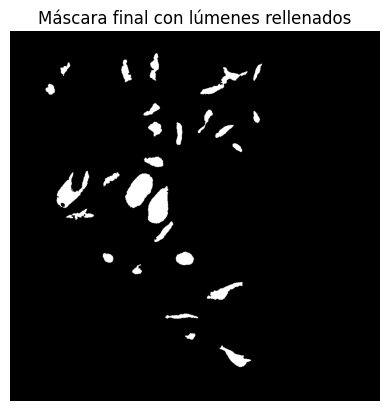

In [54]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt

# grown_manual contiene la máscara binaria de lúmenes obtenida por region growing
# Rellenar los huecos internos en cada objeto (lumen)
filled_mask = binary_fill_holes(lumen_mask)

# Visualizar la máscara final (rellena)
plt.imshow(filled_mask, cmap='gray')
plt.title("Máscara final con lúmenes rellenados")
plt.axis('off')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

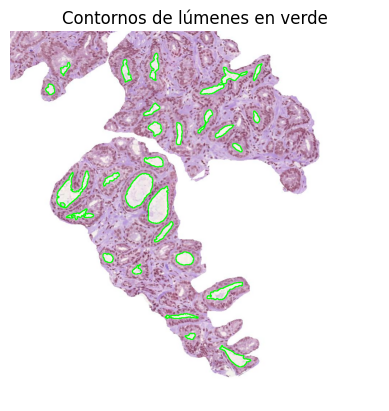

In [55]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

import cv2
import numpy as np
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

# Convertir imagen original a uint8 si está normalizada
image_uint8 = img_as_ubyte(image_normalized)

# Convertir máscara a uint8 para OpenCV
mask_uint8 = filled_mask.astype(np.uint8) * 255

# Encontrar contornos: RETR_EXTERNAL = sólo contornos externos
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar contornos en verde (BGR = (0,255,0))
image_with_contours = cv2.drawContours(
    image_uint8.copy(),    # copia para no modificar la original
    contours,
    contourIdx=-1,         # -1 = todos los contornos
    color=(0, 255, 0),     # verde en BGR
    thickness=2            # grosor visible
)

# Convertir a RGB para mostrar correctamente con matplotlib
image_rgb = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

# Mostrar imagen con contornos
plt.imshow(image_rgb)
plt.title("Contornos de lúmenes en verde")
plt.axis('off')
plt.show()


#### 7) Identificar y cropear el lumen más grande

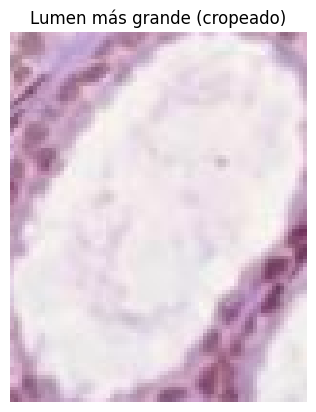

In [56]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import cv2
from skimage import img_as_ubyte

# Asegurar que la imagen esté en formato uint8 para visualización
image_uint8 = img_as_ubyte(image_normalized)

# Etiquetar las regiones conectadas en la máscara de lúmenes
labeled_mask = label(filled_mask)

# Obtener todas las regiones conectadas
regions = regionprops(labeled_mask)

# Encontrar la región con mayor área (lumen más grande)
largest_region = max(regions, key=lambda r: r.area)

# Obtener la bounding box (y0, x0, y1, x1)
y0, x0, y1, x1 = largest_region.bbox

# Realizar el crop sobre la imagen original
cropped_lumen = image_uint8[y0:y1, x0:x1]

# Visualizar el lumen cropeado
plt.imshow(cv2.cvtColor(cropped_lumen, cv2.COLOR_BGR2RGB))
plt.title("Lumen más grande (cropeado)")
plt.axis('off')
plt.show()



#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [58]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

import numpy as np
import cv2
from skimage.measure import regionprops, label
from math import pi

# --- partimos de `largest_region` (ya tienes y0,x0,y1,x1, área, perímetro, etc.) ---
r = largest_region                      # alias corto

# 1) Área
area = r.area

# 2) Área de la bounding box
bbox_area = r.bbox_area

# 3) Área convexa
convex_area = r.convex_area

# 4) Excentricidad
eccentricity = r.eccentricity

# 5) Diámetro equivalente
equiv_diam = r.equivalent_diameter

# 6) Extensión
extent = r.extent                       # área / área bbox

# 7) Diámetro Feret  (máx. distancia entre vértices del casco convexo)
coords = r.coords[:, ::-1].astype(np.float32)          # (x,y)
hull   = cv2.convexHull(coords)
feret  = max(
    np.linalg.norm(hull[i] - hull[j])
    for i in range(len(hull))
    for j in range(i + 1, len(hull))
)

# 8) Longitud del eje mayor
major_axis = r.major_axis_length

# 9) Longitud del eje menor
minor_axis = r.minor_axis_length

# 10) Orientación  (rad)
orientation = r.orientation

# 11) Perímetro
perimeter = r.perimeter

# 12) Solidez
solidity = r.solidity                   # área / área convexa

# 13) Compacidad   (P² / 4πA)
compactness = (perimeter ** 2) / (4 * pi * area)

# ------- presentar todo redondeado a 4 decimales -------
features = {
    "Área":                 round(area,            4),
    "BBox area":            round(bbox_area,       4),
    "Área convexa":         round(convex_area,     4),
    "Excentricidad":        round(eccentricity,    4),
    "Diám. equivalente":    round(equiv_diam,      4),
    "Extensión":            round(extent,          4),
    "Diám. Feret":          round(feret,           4),
    "Eje mayor":            round(major_axis,      4),
    "Eje menor":            round(minor_axis,      4),
    "Orientación (rad)":    round(orientation,     4),
    "Perímetro":            round(perimeter,       4),
    "Solidez":              round(solidity,        4),
    "Compacidad":           round(compactness,     4),
}

for k, v in features.items():
    print(f"{k:>18}: {v}")



              Área: 4701.0
         BBox area: 7392.0
      Área convexa: 4890.0
     Excentricidad: 0.8382
 Diám. equivalente: 77.366
         Extensión: 0.636
       Diám. Feret: 103.94229888916016
         Eje mayor: 105.0403
         Eje menor: 57.2888
 Orientación (rad): -0.5615
         Perímetro: 284.9777
           Solidez: 0.9613
        Compacidad: 1.3747
